## A citation map of modern economics


Some useful tools:


* [Metaknowledge](http://networkslab.org/metaknowledge/) which we will use to parse the data from the WebOfScience-data.
* [UMAP](https://github.com/lmcinnes/umap) which we will use for the embedding of the data.
* [hdbscan](https://hdbscan.readthedocs.io/en/latest/index.html) which we will use to do the clustering.


## Literature


* McInnes L, Healy J. *Accelerated Hierarchical Density Based Clustering* In: 2017 IEEE International Conference on Data Mining Workshops (ICDMW), IEEE, pp 33-42. 2017

* McInnes, L, Healy, J, *UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction*, ArXiv e-prints 1802.03426, 2018

* Reid McIlroy-Young, John McLevey, and Jillian Anderson. 2015. *metaknowledge: open source software for social networks, bibliometrics, and sociology of knowledge research.* URL: http://www.networkslab.org/metaknowledge.








In [1]:
import metaknowledge as mk
import pandas as pd
import numpy as np
from random import randint
import datetime
import scipy as scipy

%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

#For Tables:
from IPython.display import display
from IPython.display import Latex
pd.set_option('display.max_columns', 500)

#For R (ggplot2)
%load_ext rpy2.ipython

Load the WOS-data:

In [2]:
date_string = datetime.datetime.now().strftime("%Y-%m-%d-%H:%M")


RC = mk.RecordCollection("big_five")


In [3]:
# print(RC.glimpse())
RC2 = mk.RecordCollection()

for R in RC:
    randnr = randint(0, 4)
    
    if len(R.getCitations().get("author"))>=1: # and randnr==0 apply condition in order to downsample records
        #Here we kick out every paper that cites less then 3 authors. Why? because they
        #are so dissimilar from the others, that they only produce noise.  
   
        try:
            R['year']
            #if R['year']>1961:
            #R['abstract']  #Add this when working with abstracts. It removes every paper that has none. 
            #This can sometimes remove whole journals, that are archived without abstracts, so handle with care.
            RC2.add(R)
        except KeyError:
            pass
    else:
        pass
    

print(RC2.glimpse())


RC = RC2


RecordCollection glimpse made at: 2018-10-15 14:59:07
25354 Records from Empty

Top Authors
1 [Anonymous]
2 STIGLITZ, JE
3 Acemoglu, Daron
4 FISHER, FM
5 BAUMOL, WJ
6 FELDSTEIN, M
7 HELPMAN, E
7 SMITH, VL
8 POLLAK, RA
8 LAFFONT, JJ
9 Knight, Frank H.
9 TIROLE, J
9 SUMMERS, LH
10 SAMUELSON, PA
10 GRILICHES, Z
10 List, John A.
10 Douglas, Paul H.
10 AKERLOF, GA
11 ARROW, KJ
11 BARRO, RJ
11 Farhi, Emmanuel
12 BECKER, GS

Top Journals
1 AMERICAN ECONOMIC REVIEW
2 JOURNAL OF POLITICAL ECONOMY
3 ECONOMETRICA
4 QUARTERLY JOURNAL OF ECONOMICS
5 REVIEW OF ECONOMIC STUDIES

Top Cited
1 HANSEN LP, 1982, ECONOMETRICA, V50, P1029, DOI 10.2307/1912775
2 Friedman M., 1957, THEORY CONSUMPTION F
3 Debreu G, 1959, THEORY VALUE
4 WHITE H, 1980, ECONOMETRICA, V48, P817, DOI 10.2307/1912934
5 KAHNEMAN D, 1979, ECONOMETRICA, V47, P263, DOI 10.2307/1914185
6 LUCAS RE, 1988, J MONETARY ECON, V22, P3, DOI 10.1016/0304-3932(88)90168-7
6 GROSSMAN SJ, 1986, J POLIT ECON, V94, P691, DOI 10.1086/261404
7 Keynes J. 

Above we have some statistics about the data we are working with. We have lost roughly 2000 records where data was missing. The summaries show us the most prolific authors, the journals with the most occurences and the most cited single works. All of this makes sense so far. We have the incredibly popular David Lewis with multiple mentions in the the the top cited works, along with some other very well known recent authors, and of course the most influential of classics, Aristotle & Hume.


### Extracting the Features

In order to use UMAP and the clustering algorithm, we have to extract some features to work with. 

I have chosen to use two kinds:
+ cited works *and*
+ cited authors

*Cited works* are the precise citation string that the WOS-Collection uses. These are very good to get the fine-grained structure of the literature, as they can be very specific. They allow us for example to differentiate between the epistemologic and the political works of Robert Nozick. Cited authors on the other hand are to a certain extent redundant, as they are only a less precise form of cited works. 
But they are valuable for us, as they give us a general corner in which a paper belongs. This allows us to use much more of our data, as relying only on cited works forces us to kick out many papers that are only weakly linked to the rest. 
I have done some experiments with various combinations of vectorizations (author, work, words in abstract, title, etc.) and their combinations on labeled data, and the results of combining works and authors seems to work best. Look here for a little [*proof of concept*](https://github.com/MNoichl/Proof-of-concept-for-literature-clustering-with-UMAP-HDBSCAN/blob/master/proof_of_concept.ipynb) that shows how well we can differentiate different disciplines.

Both types of features are extracted with scikit-learn and concatenated. Than we filter out everything that is weakly linked, as it tends to "ball up" in the UMAP without containing useful information.

In [4]:
########### Cited Works - Features ############

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
drc = pd.DataFrame.from_dict(RC.forNLP(extraColumns=['journal','AU','FU','PD']))

d = []
citedAU = []
citestring =[]
for R in RC:

    d.append(list(set(R.getCitations().get("citeString")))) #To cluster by cited author
    citedAU.append(list(set(R.getCitations().get("author"))))
    citestring.append(list(set(R.getCitations().get("citeString"))))

drc["citedAU"] = citedAU
drc["citestring"] = citestring
#print(d[0])
authorslist = ['§'.join(filter(None,x)) for x in list(d)] 
#print(authorslist[0])

# vec = TfidfVectorizer(token_pattern=r'(?<=[^|§])[\s\w,\.:;]+(?=[$|§])')
vec = CountVectorizer(token_pattern=r'(?<=[§])[\s\w,\.:;\/\[\]-]+(?=[§])',binary=True, min_df = 3)#, min_df = 1)


Xrc = vec.fit_transform(authorslist)

In [5]:
########### Authors - Features ############

d = []
for R in RC:
    authors = list(set(R.getCitations().get("author")))
#    print(authors)
    authors = filter(None, authors)
    f = []
    for a in authors:
        f.append(' '.join([w for w in a.split(' ')if len(w)>2]))
        
    authors = f#' '.join(f)
    d.append(authors)
authorslist = [';'.join(filter(None,x)) for x in list(d)] 
vec = CountVectorizer(token_pattern=r'(?<=[;])[\s\w]+(?=[;])',binary=True, min_df = 10)

XrcAu = vec.fit_transform(authorslist)

In [6]:
k = [Xrc]#XrcAu,
XrcFull = scipy.sparse.hstack(k).tocsr()

In [7]:
###### Filtering #######
from scipy.sparse import coo_matrix, vstack
from scipy.sparse import csr_matrix
import scipy as scipy
row_names = np.array(drc["id"])

newdf=[]
a = 0
# index by name:
for x in range(0,XrcFull.shape[0]): #Xrc.shape[0]):
    row_idx, = np.where(row_names == drc["id"][x])
    if np.diff(XrcFull[row_idx].tocsr().indptr) >= 3:
        if a == 0:
            k = [XrcFull[row_idx]]
        if a != 0:
            k.append(XrcFull[row_idx])
        a = a+1
        newdf.append(drc.loc[x])
        
drc = pd.DataFrame(newdf).reset_index()
M = scipy.sparse.vstack((k))

In [8]:
print(len(drc))

15394


In [9]:
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=50, n_iter=7, random_state=42)

XSVD = SVD.fit_transform(M)
print(SVD.explained_variance_ratio_.sum())
dSVD = pd.DataFrame(XSVD)

sSVD = dSVD[[0,1]]
sSVD.columns = ['x','y']

0.06294323685792713


### Now for the [UMAP](https://github.com/lmcinnes/umap)

Umap is pretty young technique for dimensionality reduction, which has the big advantage of beeing pretty fast. And it seems to preserve global structure quite reliably, which is nice, as it enables us to cluster afterwards.
We will plot the 2D-embedding with ggplot, so that we have something to look at:

In [10]:
import umap

try:
    drc = drc.drop('x',axis=1)
    drc = drc.drop('y',axis=1)

except KeyError:
    pass


embedding = umap.UMAP(n_neighbors = 10,#small => local, large => global: 5-50
                      min_dist = 0.05, #small => local, large => global: 0.001-0.5
                      spread = 1.7,
                      metric='cosine').fit_transform(XSVD)
embedding = pd.DataFrame(embedding)
embedding.columns = ['x','y']


C:\Users\user\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:190: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


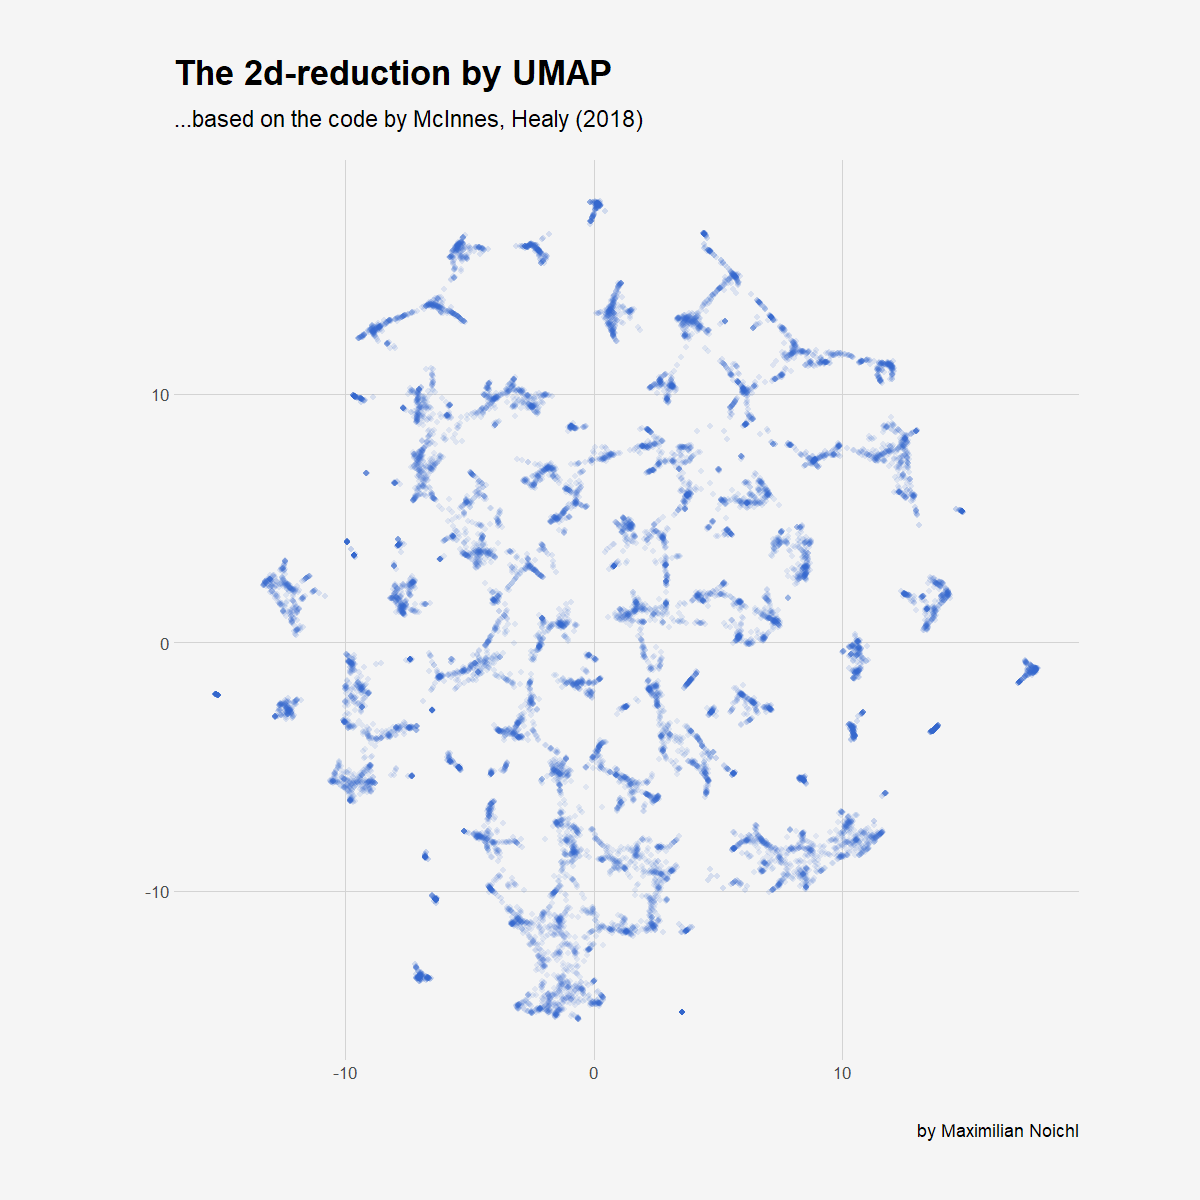

In [11]:
%%R -i embedding --width 1200 --height 1200 -r 140 --bg #F5F5F5
library(hrbrthemes)
library(ggplot2)
library(fields)
embedding$density <- fields::interp.surface(
  MASS::kde2d(embedding$x, embedding$y), embedding[,c("x","y")])

p <- ggplot(embedding, aes(x=embedding$x, y=embedding$y,alpha = 1/density))+

 guides(alpha=FALSE)+

geom_point(color="#3366cc", pch=16,cex=1.2)+ theme_ipsum_rc()+
coord_fixed()+
labs(x="", y="",
       title="The 2d-reduction by UMAP",
       subtitle="...based on the code by McInnes, Healy (2018)",
       caption="by Maximilian Noichl")+
theme(panel.grid.major = element_line(colour = "lightgrey"),panel.grid.minor = element_blank()
)
p


In [12]:
drc['timestamp'] = drc["year"] + drc["PD"].fillna(0).replace('', 0, regex=True)/12

In [13]:

n_neighbors = 7
embeddingI = umap.UMAP(n_components=1,
                        n_neighbors=n_neighbors,
                      min_dist=0.008,
                       spread = 0.8,
                      metric='cosine').fit(XSVD)

# coordinates = []
# for year in range(int(drc["year"].min()),int(drc["year"].max())):
#     l = list(np.where(drc["year"] == year)[0])
#     L = XSVD[l]     

#     emb = embeddingI.transform(L)
#     emb = pd.DataFrame(emb)
#     emb.columns = ['xI']

#     emb["year"] = drc.iloc[l,:]["timestamp"].tolist()
#     coordinates.append(emb)

# coordinates = pd.concat(coordinates, ignore_index=True)

embeddingI = pd.DataFrame(embeddingI.embedding_)
embeddingI.columns = ['xI']
embeddingI["year"] = drc["timestamp"].tolist()


C:\Users\user\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:190: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


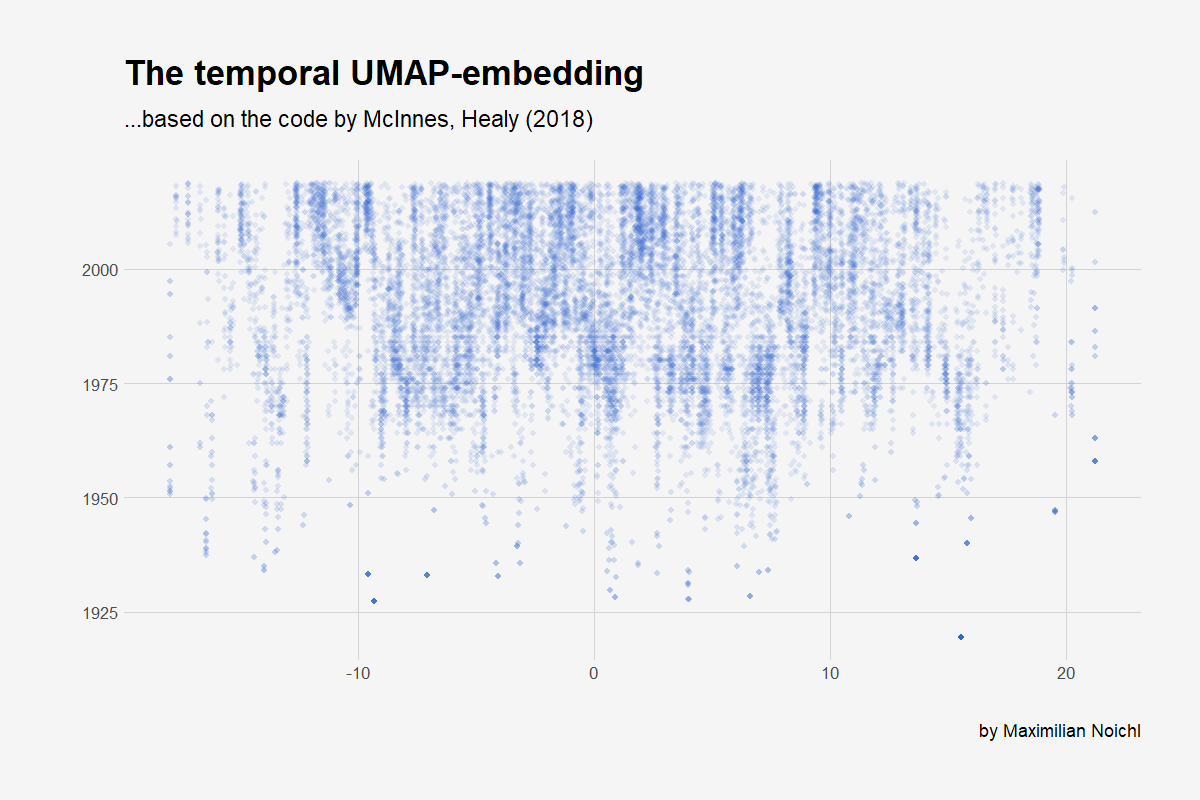

In [14]:
%%R -i embeddingI --width 1200 --height 800 -r 140 --bg #F5F5F5
library(hrbrthemes)
library(ggplot2)
library(fields)
embeddingI$density <- fields::interp.surface(
  MASS::kde2d(embeddingI$xI, embeddingI$year), embeddingI[,c("xI","year")])

p <- ggplot(embeddingI, aes(x=embeddingI$xI, y=embeddingI$year,alpha =1/density))+#1/density

 guides(alpha=FALSE)+

geom_point(color="#3366cc", pch=16,cex=1.2)+ theme_ipsum_rc()+
labs(x="", y="",
       title="The temporal UMAP-embedding",
       subtitle="...based on the code by McInnes, Healy (2018)",
       caption="by Maximilian Noichl")+
theme(panel.grid.major = element_line(colour = "lightgrey"),panel.grid.minor = element_blank()
)
p


As you can see, the web of science started to archive the *months* of publishing only in the late eighties, which is why the plot has these lines at the bottom, where we can assign only years to the publications. 

### Clustering with [HDBSCAN](https://github.com/scikit-learn-contrib/hdbscan)

Now we use HDBSCAN to cluster our data:


In [19]:
try:
    drc = drc.drop('cluster',axis=1)
except KeyError:
    pass

import hdbscan

#(min_cluster_size=500, min_samples=30, gen_min_span_tree=True)
#clusterer = hdbscan.HDBSCAN(min_cluster_size=455, min_samples=35, gen_min_span_tree=True)

clusterer = hdbscan.HDBSCAN(min_cluster_size=300, min_samples=40, gen_min_span_tree=True)
clusterer.fit(embedding)
XCLUST = clusterer.labels_
clusternum = len(set( clusterer.labels_))-1


dfclust = pd.DataFrame(XCLUST)
dfclust.columns = ['cluster']


print(clusternum)
### Let's play a little sound when we're done:
# import winsound
# winsound.Beep(550,300)

22


Now lets plot everything in ggplot:

C:\Users\user\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:190: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


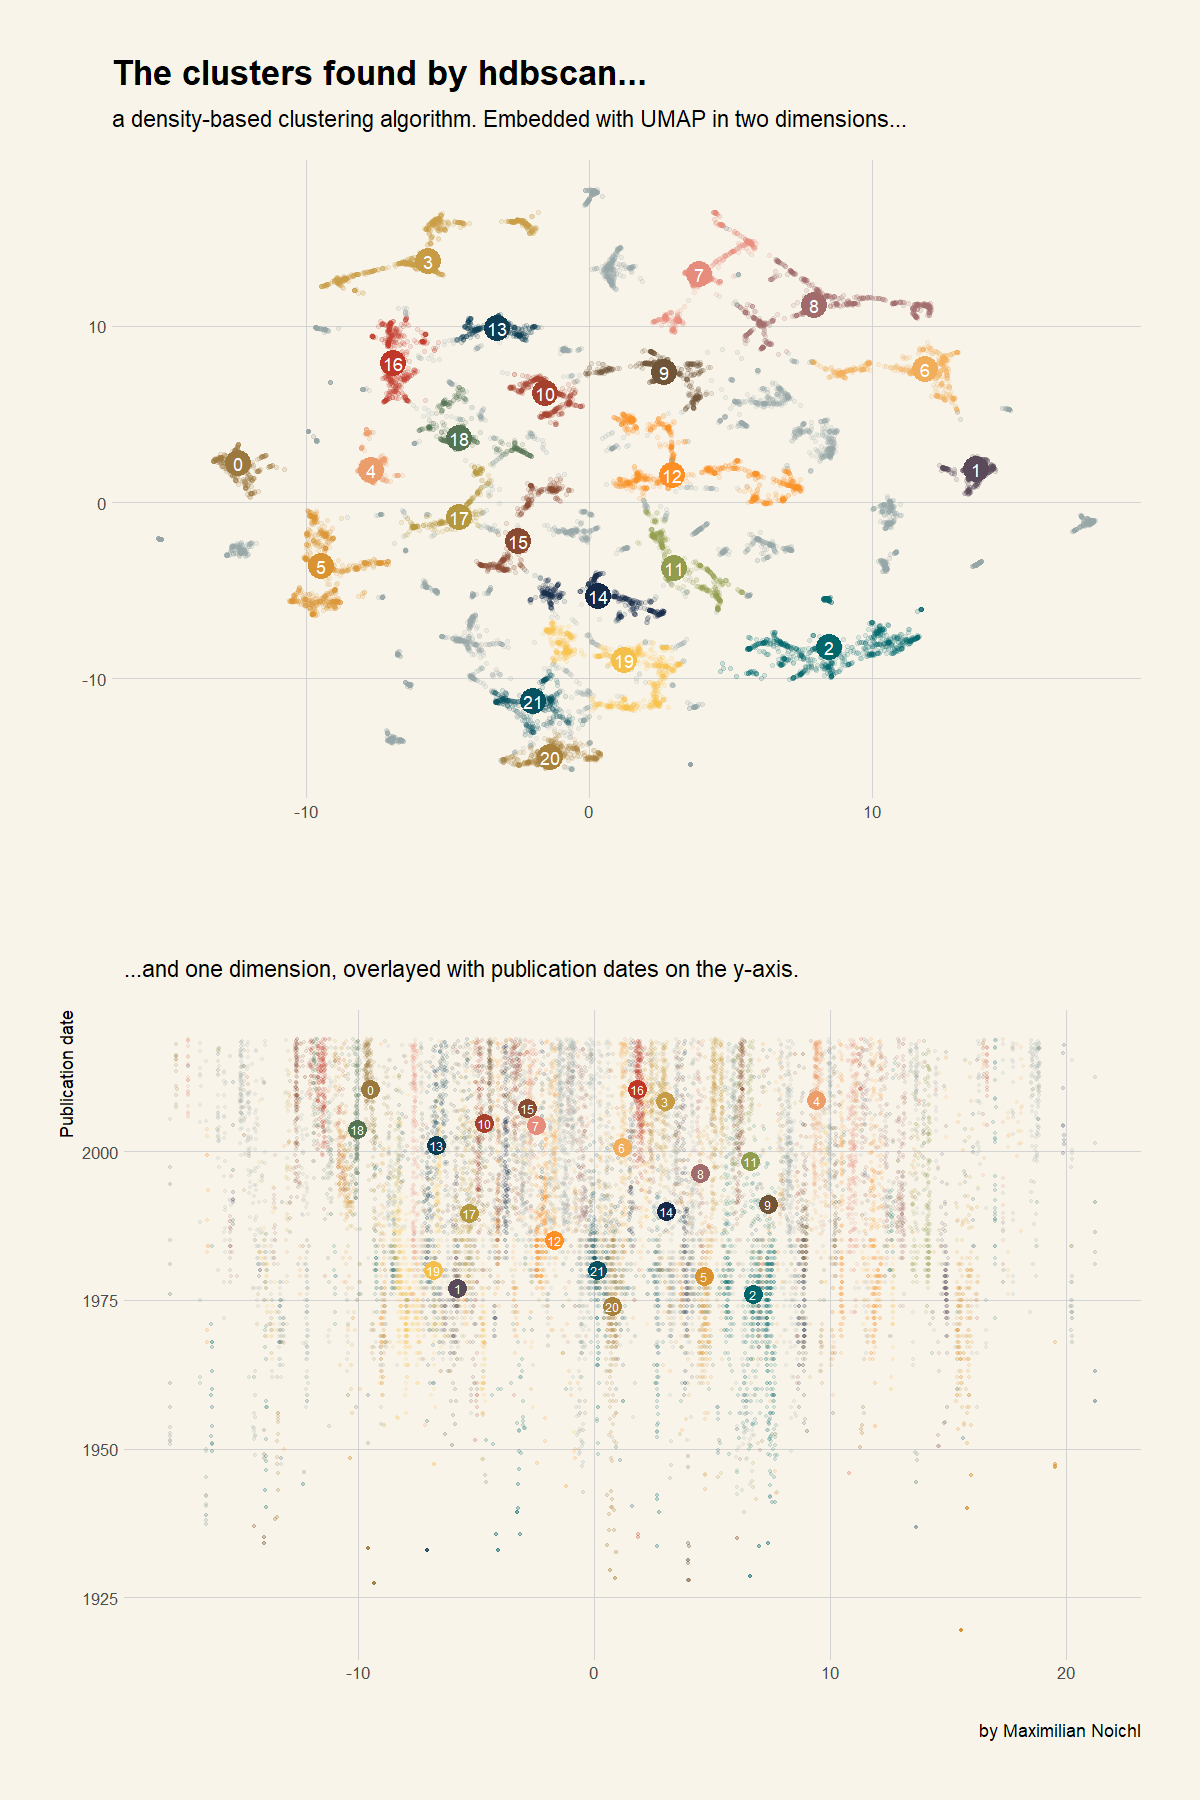

In [20]:
%%R -i embedding,dfclust,embeddingI -o myNewColors,tmeans --width 1200 --height 1800 -r 140 --bg #F8F4E9

library(hrbrthemes)
library(ggplot2)
library(fields)
library(plyr)
options(warn=0)# 0 zum anschalten

#Get the cluster means:
means <- aggregate(embedding[,c("x","y")], list(dfclust$cluster), median)
means <- data.frame(means) 
n=nrow(means)
means <- means[-1,]

#Make the colors: 
mycolors <- c("#c03728","#919c4c","#fd8f24","#f5c04a","#e68c7c","#00666b","#142948","#6f5438") 

pal <- colorRampPalette(sample(mycolors))
s <- n-1
myGray <- c('#95a5a6')
myNewColors <- sample(pal(s))
myPal <- append(myGray,myNewColors)

#get temporal means:
tmeans <- aggregate(embeddingI[,c("xI","year")], list(dfclust$cluster), median)
tmeans <- data.frame(tmeans) 
tmeans <- tmeans[-1,]




#get density, to avoid overplotting
embedding$density <- fields::interp.surface(
  MASS::kde2d(embedding$x, embedding$y), embedding[,c("x","y")])

#get temporal density
embeddingI$density <- fields::interp.surface(
  MASS::kde2d(embeddingI$xI, embeddingI$year), embeddingI[,c("xI","year")])


p <- ggplot(embedding, aes(x=embedding$x, y=embedding$y, color= as.factor(dfclust$cluster), alpha = 1/density))+
geom_point(pch=20,cex=1.6)+ 
theme_ipsum_rc()+
scale_color_manual(values = myPal) +
 guides(alpha=FALSE, color=FALSE)+
geom_point(data=means, aes(x=means$x, y=means$y), color= myNewColors, alpha = 1,size =6)+
annotate("text", x = means[,c("x")], y = means[,c("y")], label = means[,c("Group.1")], color="white", fontface="bold",  size=3.2, parse = TRUE, hjust=0.5)+
labs(x="", y="",
       title="The clusters found by hdbscan...",
       subtitle="a density-based clustering algorithm. Embedded with UMAP in two dimensions...")+
theme(panel.grid.major = element_line(colour = "lightgrey"),panel.grid.minor = element_blank())


t <- ggplot(embeddingI, aes(x=embeddingI$xI, y=embeddingI$year, color= as.factor(dfclust$cluster), alpha = 1/density))+
geom_point(pch=20,cex=1.2)+
theme_ipsum_rc()+
scale_color_manual(values = myPal) +
guides(alpha=FALSE, color=FALSE)+
geom_point(data=tmeans, aes(x=tmeans$x, y=tmeans$y), color= myNewColors, alpha = 1,size =4.2)+
annotate("text", x = tmeans[,c("xI")], y = tmeans[,c("year")], label = tmeans[,c("Group.1")], color="white", fontface="bold",  size=2.2, parse = TRUE, hjust=0.5)+
labs(x="", y="Publication date",
         subtitle="...and one dimension, overlayed with publication dates on the y-axis.",
       caption="by Maximilian Noichl")+
theme(panel.grid.major = element_line(colour = "lightgrey"),panel.grid.minor = element_blank())


library(gridExtra)
grid.arrange(p,t, ncol = 1,  heights = c(1, 1))

# pdf("ClusteringUMap.pdf", width = 12, height = 12) # Open a new pdf file
# grid.arrange(p,t, ncol = 1,  heights = c(1, 1)) # Write the grid.arrange in the file\n",
# dev.off()



Thats nice. To have look into the way the clustering algorithm has structured the data, lets look at the condensed tree.  
I messed around a bit in my installation of HDBSCAN, so if you run this on your computer, your tree will propably look quite different.
The condensed clustering tree basically tells us, when the algorithm found it necessary to break a group apart into two smaller clusters. On the left of the tree we see the clusters that were so far removed from the central structure, that they broke off at the very beginning of the clustering process.

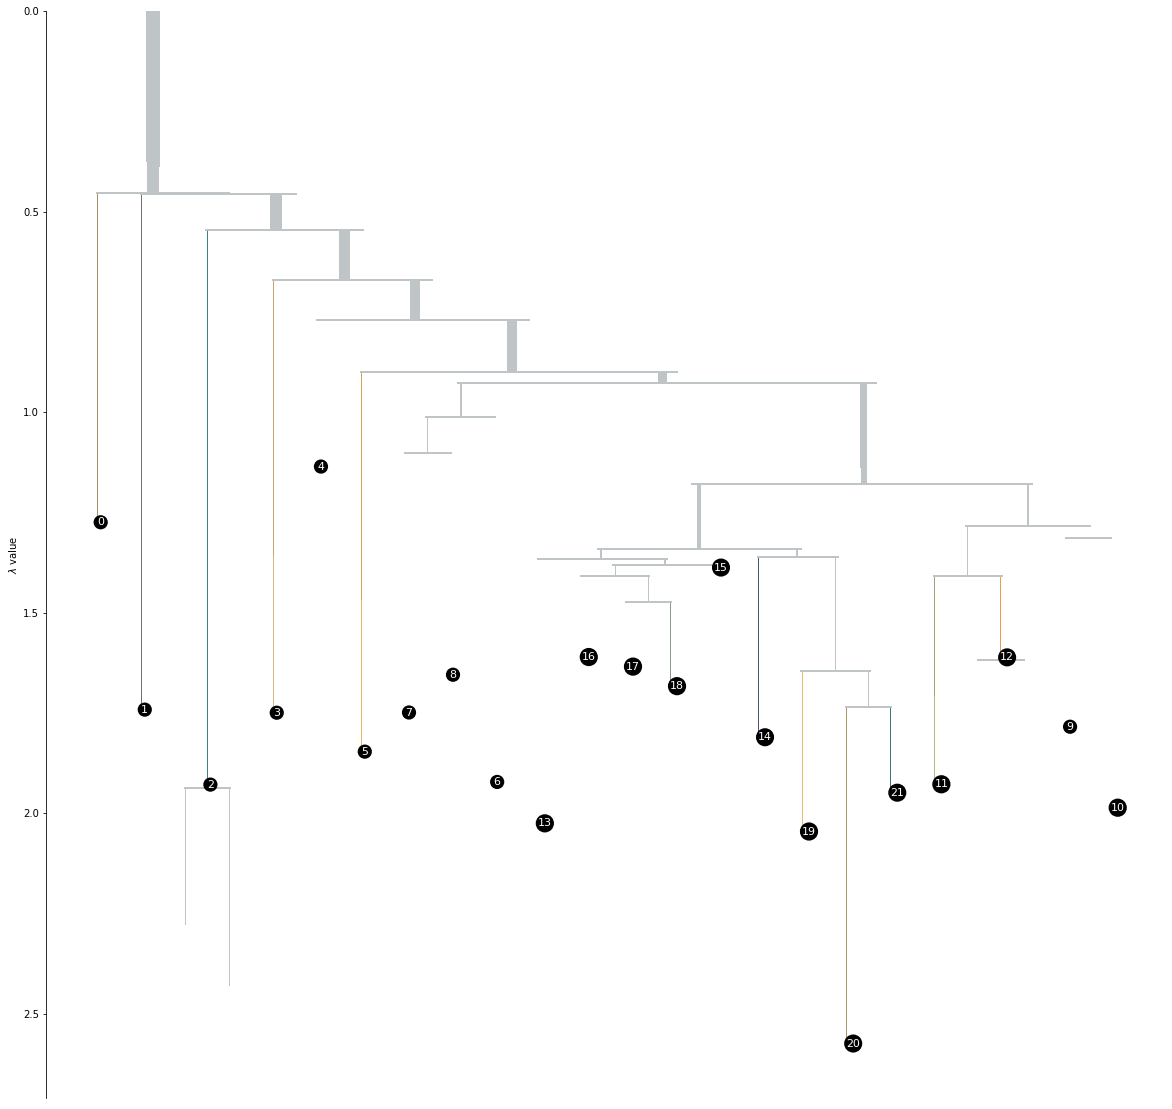

In [21]:
import matplotlib.colors
plt.rcParams['figure.figsize'] = [20, 20]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#bfc4c6","#bfc4c6","#bfc4c6"])

clusterer.condensed_tree_.plot(cmap = cmap,select_clusters=True,label_clusters = True, selection_palette=myNewColors, 
                               colorbar = False,max_rectangles_per_icicle=80, alpha=0.7,barwidthfactor=0.3,linecolor='#bfc4c6',linewidth=2)


### What does it mean?
Now, let us look into the clusters, to find out what they actually contain. First we shall analyze the abstracts of the papers in every cluster according to their most common words and bigrams. In the tables below, every column is a cluster, and every row is a common word. Then we will do the exact same thing with the most cited authors.

In [22]:

drc = pd.concat([drc, dfclust],axis=1)
drc = drc.dropna(subset=['cluster'])
drc = pd.concat([drc, embedding],axis=1)


In [23]:
embedding.to_csv("embedding.csv")

In [24]:
fullstrsl = []
for x in range(0,clusternum):
    abstracts = list(drc.loc[drc['cluster'] == x]['abstract'])
    abstracts = ";".join(str(x) for x in abstracts).replace('|',' ').replace('paper',' ').replace('argue',' ').replace('account',' ').replace('theory',' ') #kick out common abstract words of no importance
    fullstrsl.append(abstracts)
    
vec = CountVectorizer( stop_words='english')#Choose CountVectorizer for the most common words in the cluster, TfidfVectorizer for the words with the greatest differentiation value.
X = vec.fit_transform(fullstrsl)
#print(pd.DataFrame(X.toarray(), columns=vec.get_feature_names())) #To look into the vectors. Beware, can take a bit of RAM


clusterfeatures = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
fullscore = []
for x in range(0,clusternum):
    scores = zip(vec.get_feature_names(), np.asarray(X[x,:].sum(axis=0)).ravel())
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    myscores = sorted_scores[0:20]
    
    scorelist = []
    for s in myscores:
        scorelist.append(s[0])
    fullscore.append(scorelist)
display(pd.DataFrame(fullscore).transpose())



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,trade,choice,demand,model,financial,growth,information,information,equilibrium,model,growth,model,model,policy,model,model,effects,model,wage,tests,monetary,inflation
1,model,social,equilibrium,preferences,model,capital,optimal,model,information,market,firms,models,workers,model,models,consumption,data,child,labor,asymptotic,money,model
2,firms,agents,market,behavior,credit,countries,auction,market,games,price,model,nonparametric,wage,political,market,risk,countries,effects,growth,test,model,price
3,countries,individual,model,equilibrium,debt,model,auctions,incentives,players,demand,productivity,estimator,market,voters,data,income,model,children,workers,model,rates,shocks
4,data,preferences,economy,subjects,firms,income,model,agents,model,prices,data,data,data,government,returns,data,using,parents,effects,data,real,policy
5,productivity,function,data,results,banks,productivity,equilibrium,equilibrium,game,firms,firm,distribution,firms,public,stock,asset,effect,income,inequality,models,rate,debt
6,costs,individuals,preferences,risk,risk,economic,bidders,optimal,equilibria,competition,market,effects,prices,voting,information,households,economic,capital,model,time,assets,monetary
7,export,utility,price,data,bank,investment,private,firms,agents,data,new,estimators,price,equilibrium,prices,prices,evidence,data,data,series,inflation,prices
8,prices,axioms,prices,choice,capital,production,price,performance,bargaining,welfare,size,identification,wages,spending,estimators,using,school,family,education,estimator,costs,rate
9,international,set,results,utility,markets,data,tax,contracts,market,equilibrium,technology,treatment,capital,electoral,empirical,shocks,social,equilibrium,wages,regression,cost,process


In [25]:
fullstrsl = []
for x in range(0,clusternum):
    abstracts = list(drc.loc[drc['cluster'] == x]['abstract'])
    abstracts = ";".join(str(x) for x in abstracts).replace('|',' ').replace('paper',' ').replace('reserved',' ').replace('argue',' ').replace('account',' ').replace('theory',' ')
    fullstrsl.append(abstracts)
    
vec = CountVectorizer( stop_words='english', ngram_range=(2, 2))#Choose CountVectorizer for the most common words in the cluster, TfidfVectorizer for the words with the greatest differentiation value.
X = vec.fit_transform(fullstrsl)
#print(pd.DataFrame(X.toarray(), columns=vec.get_feature_names())) #To look into the vectors. Beware, can take a bit of RAM


clusterfeatures = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
fullscore = []
for x in range(0,clusternum):
    scores = zip(vec.get_feature_names(), np.asarray(X[x,:].sum(axis=0)).ravel())
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    myscores = sorted_scores[0:20]
    
    scorelist = []
    for s in myscores:
        scorelist.append(s[0])
    fullscore.append(scorelist)
display(pd.DataFrame(fullscore).transpose())



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,international trade,social choice,revealed preference,expected utility,monetary policy,human capital,private information,adverse selection,nash equilibrium,price discrimination,united states,panel data,human capital,public good,stock returns,equity premium,regression discontinuity,social security,human capital,time series,monetary policy,monetary policy
1,trade costs,choice function,general equilibrium,nash equilibrium,ex ante,economic growth,social choice,private information,private information,using data,entry exit,monte carlo,united states,united states,asset pricing,asset pricing,test scores,human capital,united states,unit root,cost inflation,price level
2,comparative advantage,social welfare,utility function,loss aversion,equilibrium model,productivity growth,ex post,moral hazard,repeated games,dynamic model,firm size,treatment effects,labor market,median voter,method moments,asset prices,percentage points,marriage market,wage inequality,test statistics,welfare cost,funds rate
3,exchange rate,independence irrelevant,sufficient conditions,risk aversion,general equilibrium,growth model,income tax,asymmetric information,incomplete information,welfare effects,size distribution,confidence intervals,public goods,political competition,generalized method,risk aversion,human capital,ricardian equivalence,labor market,confidence intervals,money demand,money supply
4,general equilibrium,irrelevant alternatives,necessary sufficient,reference point,financial markets,capital accumulation,nash equilibrium,decision maker,common knowledge,consumer surplus,growth model,propensity score,general equilibrium,public goods,moment restrictions,consumption growth,labor market,sex ratios,technological change,finite sample,demand currency,rational expectations
5,trade flows,linear invariance,finite number,social preferences,financial crises,growth rates,private values,ex ante,repeated game,data set,growth rate,treatment effect,price changes,policy choices,stock market,income risk,property rights,family size,high school,maximum likelihood,nominal rate,steady state
6,trade liberalization,choice behavior,large finite,ex ante,moral hazard,endogenous growth,public good,decision making,sequential equilibrium,differentiated products,productivity growth,asymptotically normal,equilibrium model,government spending,conditional moment,risk premia,using data,birth order,labor supply,monte carlo,real rates,convergence fie
7,trade model,choice functions,demand function,public goods,aggregate demand,physical capital,adverse selection,results suggest,folk theorem,exclusive dealing,economic growth,quantile regression,labor supply,policy preferences,stock prices,life cycle,class size,child labor,technical change,null hypothesis,exchange rates,cumulative process
8,free trade,euclidean index,differential information,field experiment,asset prices,production function,incentive compatibility,test scores,perfect equilibrium,adverse selection,endogenous growth,identification estimation,higher wages,political economy,empirical likelihood,labor income,high school,bequest motive,instrumental variables,serial correlation,inflation rate,federal reserve
9,heterogeneous firms,feasible set,economy differential,decision maker,financial crisis,capital investment,mechanism design,ex post,discount factor,consumer welfare,growth rates,fixed effects,hours worked,tax rates,time series,social security,peer effects,labor force,labor force,unit roots,interestbearing assets,government spending


In [26]:
fullstrsl = []
for x in range(0,clusternum):
    authors = list(drc.loc[drc['cluster'] == x]['citedAU'])
    authors = [item for sublist in authors for item in sublist]
    authors = " §".join(str(x) for x in authors)
    authors = ' '.join( [w for w in authors.split() if len(w)>2] )
    fullstrsl.append(authors)

#print(fullstrsl[1])
vec = CountVectorizer(token_pattern=r'[\s\w\.-]+(?=[$|§])')#Choose CountVectorizer for the most common words in the cluster, TfidfVectorizer for the words with the greatest differentiation value.
X = vec.fit_transform(fullstrsl)

clusterfeatures = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
fullscoreA = []
for x in range(0,clusternum):
    scores = zip(vec.get_feature_names(), np.asarray(X[x,:].sum(axis=0)).ravel())
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    myscores = sorted_scores[0:10]
    
    scorelist = []
    for s in myscores:
        scorelist.append(s[0])
    fullscoreA.append(scorelist)
display(pd.DataFrame(fullscoreA).transpose())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,feenstra,sen,samuelson,camerer,bernanke,solow,milgrom,holmstrom,fudenberg,berry,grossman,heckman,becker,alesina,hansen,campbell,acemoglu,becker,katz,anderson,friedman,lucas
1,bernard,arrow,arrow,kahneman,diamond,arrow,myerson,akerlof,harsanyi,dixit,lucas,hausman,rosen,besley,fama,hansen,alesina,barro,heckman,phillips pcb,keynes,sargent
2,krugman,fishburn,debreu,fehr,kiyotaki,romer,maskin,milgrom,kreps,spence,romer,newey,mincer,persson,sharpe,hall,glaeser,feldstein,card,sargan,tobin,friedman
3,helpman,luce,hicks,thaler,stiglitz,samuelson,wilson,lazear,rubinstein,hotelling,aghion,manski,hall,downs,lintner,attanasio,,diamond,autor,hall,patinkin,barro
4,eaton,black,gorman,tversky,gertler,jorgenson,mirrlees,grossman,abreu,bresnahan,jovanovic,imbens,gordon,grossman,newey,epstein,angrist,samuelson,acemoglu,theil,hicks,muth
5,melitz,samuelson,diewert,laibson,holmstrom,lucas,laffont,rothschild,milgrom,dasgupta,hall,lee,akerlof,stigler,merton,cochrane,barro,kotlikoff,becker,engle,fisher,sims
6,grossman,rawls,houthakker,rabin,hart,none,mcafee,crawford,binmore,salop,hopenhayn,blundell,azariadis,baron,tobin,deaton,lee,bernheim,angrist,zellner,baumol,frenkel
7,goldberg,pattanaik,mckenzie,andreoni,shleifer,barro,vickrey,stiglitz,selten,schmalensee,jones,chamberlain,heckman,buchanan,campbell,lucas,becker,auerbach,goldin,klein,barro,phelps
8,hummels,arrow kenneth,koopmans,bernheim,brunnermeier,kendrick,riley,spence,myerson,eaton,griliches,amemiya,smith,becker,shiller,carroll,la porta,modigliani,murphy,jorgenson,samuelson,gordon
9,anderson,harsanyi,none,becker,calomiris,denison,dasgupta,green,aumann,chamberlin,barro,horowitz,baily,peltzman,markowitz,constantinides,easterly,blinder,bound,hansen,clower,fischer


In [27]:
#Build timestamp to save stuff:
import time, os, fnmatch, shutil
t = time.localtime()
timestamp = time.strftime('%b-%d-%Y_%H%M', t)
BACKUP_NAME = ("Run-" + timestamp)

In [28]:
for x in range(0,clusternum): # INEFFICIENT!
    ID = drc.loc[drc['cluster'] == x]['id']
    ID = pd.DataFrame(ID)
    #display(ID)
    #print(ID[ID['id'].str.contains(str(R['id']))])
    RCt = mk.RecordCollection()

    for R in RC:
        if ID[ID['id'].str.contains(str(R['id']))].empty == False:
            RCt.add(R)
        else:
            pass  
    print("Cluster: " + str(x))
    print(RCt.glimpse(compact=True))#If another Tag should be of interest, just add it as string...
    RCt.writeFile(fname="Cluster Nr. _"+str(x)+"_"+BACKUP_NAME+".txt")
    with open("Clusters_Bibliographic_"+BACKUP_NAME+".txt", "w") as text_file:
        text_file.write("Cluster: " + str(x))
        text_file.write(RCt.glimpse(compact=True))

Cluster: 0
+RecordCollection glimpse made at: 2018-10-15 15:17:05++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
|320 Records from Empty++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++|
|Columns are ranked by num. of occurrences and are independent of one another++++++++++++++++++++++++++++++++++++++++++|
|-------------Top Authors--------------+-------------Top Journals--------------+---------------Top Cited---------------|
|1                     Costinot, Arnaud|1              AMERICAN ECONOMIC REVIEW|1 Melitz MJ, 2003, ECONOMETRICA, V71, .|
|2                     Helpman, Elhanan|2        QUARTERLY JOURNAL OF ECONOMICS|2 Eaton J, 2002, ECONOMETRICA, V70, P1.|
|2                  Redding, Stephen J.|3            REVIEW OF ECONOMIC STUDIES|3 KRUGMAN P, 1980, AM ECON REV, V70, P.|
|3                  Weinstein, David E.|3          JOURNAL OF POLITICAL ECONOMY|4 Bernard AB, 2003, AM ECON REV, V93, .|
|3              Rodri

Cluster: 2
+RecordCollection glimpse made at: 2018-10-15 15:18:33++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
|977 Records from Empty++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++|
|Columns are ranked by num. of occurrences and are independent of one another++++++++++++++++++++++++++++++++++++++++++|
|-------------Top Authors--------------+-------------Top Journals--------------+---------------Top Cited---------------|
|1                          DIEWERT, WE|1                          ECONOMETRICA|1          Debreu G, 1959, THEORY VALUE|
|2                         BLACKORBY, C|2              AMERICAN ECONOMIC REVIEW|2   ARROW KJ, 1971, GENERAL COMPETITIVE|
|3                         MASCOLELL, A|3            REVIEW OF ECONOMIC STUDIES|3    Hicks John R., 1946, VALUE CAPITAL|
|4                           POLLAK, RA|4        QUARTERLY JOURNAL OF ECONOMICS|4         SAMUELSON PA, 1947, F EC ANAL|
|4                   

Cluster: 4
+RecordCollection glimpse made at: 2018-10-15 15:20:24++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
|308 Records from Empty++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++|
|Columns are ranked by num. of occurrences and are independent of one another++++++++++++++++++++++++++++++++++++++++++|
|-------------Top Authors--------------+-------------Top Journals--------------+---------------Top Cited---------------|
|1                         STIGLITZ, JE|1              AMERICAN ECONOMIC REVIEW|1 Kiyotaki N, 1997, J POLIT ECON, V105.|
|2                           Mian, Atif|2        QUARTERLY JOURNAL OF ECONOMICS|2 BERNANKE B, 1989, AM ECON REV, V79, .|
|2                      Farhi, Emmanuel|3          JOURNAL OF POLITICAL ECONOMY|3 DIAMOND DW, 1983, J POLIT ECON, V91,.|
|3                           Sufi, Amir|4            REVIEW OF ECONOMIC STUDIES|4 Holmstrom B, 1997, Q J ECON, V112, P.|
|3                   

Cluster: 6
+RecordCollection glimpse made at: 2018-10-15 15:22:30++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
|551 Records from Empty++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++|
|Columns are ranked by num. of occurrences and are independent of one another++++++++++++++++++++++++++++++++++++++++++|
|-------------Top Authors--------------+-------------Top Journals--------------+---------------Top Cited---------------|
|1                          LAFFONT, JJ|1                          ECONOMETRICA|1 MILGROM PR, 1982, ECONOMETRICA, V50,.|
|2                            MASKIN, E|2              AMERICAN ECONOMIC REVIEW|2 MIRRLEES JA, 1971, REV ECON STUD, V3.|
|2                        Werning, Ivan|3            REVIEW OF ECONOMIC STUDIES|3 MYERSON RB, 1981, MATH OPER RES, V6,.|
|2                      Bergemann, Dirk|4          JOURNAL OF POLITICAL ECONOMY|4 VICKREY W, 1961, J FINANC, V16, P8, .|
|2                   

Cluster: 8
+RecordCollection glimpse made at: 2018-10-15 15:24:14++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
|694 Records from Empty++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++|
|Columns are ranked by num. of occurrences and are independent of one another++++++++++++++++++++++++++++++++++++++++++|
|-------------Top Authors--------------+-------------Top Journals--------------+---------------Top Cited---------------|
|1                         FUDENBERG, D|1                          ECONOMETRICA|1 RUBINSTEIN A, 1982, ECONOMETRICA, V5.|
|2                         CRAWFORD, VP|2            REVIEW OF ECONOMIC STUDIES|2 KREPS DM, 1982, ECONOMETRICA, V50, P.|
|3                        RUBINSTEIN, A|3              AMERICAN ECONOMIC REVIEW|3 Selten R., 1975, International Journ.|
|4                             SOBEL, J|4          JOURNAL OF POLITICAL ECONOMY|4 KREPS DM, 1982, J ECON THEORY, V27, .|
|4                   

Cluster: 10
+RecordCollection glimpse made at: 2018-10-15 15:25:40++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
|374 Records from Empty++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++|
|Columns are ranked by num. of occurrences and are independent of one another++++++++++++++++++++++++++++++++++++++++++|
|-------------Top Authors--------------+-------------Top Journals--------------+---------------Top Cited---------------|
|1                      Bloom, Nicholas|1              AMERICAN ECONOMIC REVIEW|1 AGHION P, 1992, ECONOMETRICA, V60, P.|
|2                     Van Reenen, John|2          JOURNAL OF POLITICAL ECONOMY|2 ROMER PM, 1990, J POLIT ECON, V98, p.|
|3                       Syverson, Chad|3        QUARTERLY JOURNAL OF ECONOMICS|3 Grossman G. M., 1991, INNOVATION GRO.|
|3                    Haltiwanger, John|4            REVIEW OF ECONOMIC STUDIES|4 JOVANOVIC B, 1982, ECONOMETRICA, V50.|
|3              Ross

Cluster: 12
+RecordCollection glimpse made at: 2018-10-15 15:27:23++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
|979 Records from Empty++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++|
|Columns are ranked by num. of occurrences and are independent of one another++++++++++++++++++++++++++++++++++++++++++|
|-------------Top Authors--------------+-------------Top Journals--------------+---------------Top Cited---------------|
|1                          AKERLOF, GA|1              AMERICAN ECONOMIC REVIEW|1 AZARIADIS C, 1975, J POLIT ECON, V83.|
|2                             WEISS, Y|2          JOURNAL OF POLITICAL ECONOMY|2 TIEBOUT CM, 1956, J POLIT ECON, V64,.|
|3                              BALL, L|3        QUARTERLY JOURNAL OF ECONOMICS|3        Becker G., 1964, HUMAN CAPITAL|
|3                          PARSONS, DO|4            REVIEW OF ECONOMIC STUDIES|4 BAILY MN, 1974, REV ECON STUD, V41, .|
|4                  

Cluster: 14
+RecordCollection glimpse made at: 2018-10-15 15:29:24++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
|500 Records from Empty++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++|
|Columns are ranked by num. of occurrences and are independent of one another++++++++++++++++++++++++++++++++++++++++++|
|-------------Top Authors--------------+-------------Top Journals--------------+---------------Top Cited---------------|
|1                             FAMA, EF|1              AMERICAN ECONOMIC REVIEW|1 HANSEN LP, 1982, ECONOMETRICA, V50, .|
|2                              LEVY, H|2                          ECONOMETRICA|2 SHARPE WF, 1964, J FINANC, V19, P425.|
|3                            DUFFIE, D|3          JOURNAL OF POLITICAL ECONOMY|3 LINTNER J, 1965, REV ECON STAT, V47,.|
|3                          SUMMERS, LH|4            REVIEW OF ECONOMIC STUDIES|4 Tobin J., 1958, REV ECON STUD, V67, .|
|3                  

Cluster: 16
+RecordCollection glimpse made at: 2018-10-15 15:31:29++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
|568 Records from Empty++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++|
|Columns are ranked by num. of occurrences and are independent of one another++++++++++++++++++++++++++++++++++++++++++|
|-------------Top Authors--------------+-------------Top Journals--------------+---------------Top Cited---------------|
|1                          Shleifer, A|1              AMERICAN ECONOMIC REVIEW|1 Acemoglu D, 2001, AM ECON REV, V91, .|
|2                      Acemoglu, Daron|2        QUARTERLY JOURNAL OF ECONOMICS|2 La Porta R, 1998, J POLIT ECON, V106.|
|2                   Robinson, James A.|3          JOURNAL OF POLITICAL ECONOMY|2 Hall RE, 1999, Q J ECON, V114, P83, .|
|2                         Nunn, Nathan|4            REVIEW OF ECONOMIC STUDIES|3 Kling JR, 2007, ECONOMETRICA, V75, P.|
|3                  

Cluster: 18
+RecordCollection glimpse made at: 2018-10-15 15:33:10++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
|412 Records from Empty++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++|
|Columns are ranked by num. of occurrences and are independent of one another++++++++++++++++++++++++++++++++++++++++++|
|-------------Top Authors--------------+-------------Top Journals--------------+---------------Top Cited---------------|
|1                          Acemoglu, D|1              AMERICAN ECONOMIC REVIEW|1 KATZ LF, 1992, Q J ECON, V107, P35, .|
|1                      Acemoglu, Daron|2        QUARTERLY JOURNAL OF ECONOMICS|2 IMBENS GW, 1994, ECONOMETRICA, V62, .|
|2                             Galor, O|3          JOURNAL OF POLITICAL ECONOMY|3 JUHN C, 1993, J POLIT ECON, V101, P4.|
|3                          Dorn, David|4            REVIEW OF ECONOMIC STUDIES|4 Autor DH, 1998, Q J ECON, V113, P116.|
|3                  

Cluster: 20
+RecordCollection glimpse made at: 2018-10-15 15:34:59++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
|443 Records from Empty++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++|
|Columns are ranked by num. of occurrences and are independent of one another++++++++++++++++++++++++++++++++++++++++++|
|-------------Top Authors--------------+-------------Top Journals--------------+---------------Top Cited---------------|
|1                        MODIGLIANI, F|1              AMERICAN ECONOMIC REVIEW|1 Keynes J. M., 1936, GENERAL THEORY E.|
|1                          AKERLOF, GA|2          JOURNAL OF POLITICAL ECONOMY|2 Patinkin D., 1965, MONEY INTEREST PR.|
|2                          MELTZER, AH|3        QUARTERLY JOURNAL OF ECONOMICS|3 Baumol WJ, 1952, Q J ECON, V66, P545.|
|2                           NIEHANS, J|4            REVIEW OF ECONOMIC STUDIES|4 TOBIN J, 1956, REV ECON STAT, V38, P.|
|2                  

Now for the final part that puts it all together. This last part is where my analysis stops being purely data-driven, and becomes a bit more subjective, as I choose from the data presented above labels for the clusters. I think it is quite possible to disagree about these labels, especially with clusters that still have some heterogenity left.

In [79]:
%%R -i embedding,dfclust,myNewColors -o labelpol,cltest --bg #fbf8f1
#-h 1600 -w 1600 -r 140 --bg #fbf8f1

# Some imports:
library(hrbrthemes)
library(ggplot2)
library(fields)
# library(ggrepel)
library(ggforce)
#install.packages('ggalt')
library(ggalt)
library(stringr)



options(warn=0)# 0 zum anschalten

#Get the cluster means:
means <- aggregate(embedding[,c("x","y")], list(dfclust$cluster), mean)
means <- data.frame(means)
#And Variance, for the labels:
test <- aggregate(embedding[,c("x")], list(dfclust$cluster), var)
test <- test[-1,]

n=nrow(means)
means <- means[-1,]
# #Make the colors: 
# mycolors <- c("#dd593c",
# "#ead96c",
# "#df4467",
# "#8d2315",
# "#675d69",
# "#70897b",
# "#131541") 

# pal <- colorRampPalette(sample(mycolors))
# s <- n-1
myGray <- c('#95a5a6')
# myNewColors <- sample(pal(s))
myPal <- append(myGray,myNewColors)

#fonts:
# library(showtext)
# font.add.google(name = "Alegreya Sans SC", family = "SC")
# showtext.auto()


#◇

# labels <- c("Responsibility & Free Will","Classical Logic & Paradoxes","Formal Th. of Science & Modeling","Ph. of linguistics & semantics",
#             "Formal Epistemology","Causality & Scient. Explanation","Probability & Decision Theory","History of Science",
#             "Possible Worlds & Counterfactuals",
#             "Quantum Mechanics","Epistemology: Foundationalism","Epistemology: Contextualism","Biology & Evolution",
#             "Virtue Ethics","Practical Reason","Liberalism & Legal Ph.","Moral Judgement","Art & Aesthetics","Cognitive Science",
#             "Ph. of Mind: Phenomenology","Ph. of Mind: Mental Causation","Possible Worlds: Metaphysics","Reference, Proper Names",
#             "Reference of Math. Objects","Quinean Ontology")
# labelsb <- c("J. M. Fischer, P. van Inwagen","","","",
#             "","N. Cartwright, J. Woodward","Dutch Book, Sleeping Beauty,...","Newton",
#             "",
#             "","","","",
#             "Aristotle","Kant & Hume","","","","",
#             "","","","",
#             "","")
#circular markers:  
library(gridExtra)

circle <- polygon_regular(100)
pointy_points <- function(x, y, size){
  do.call(rbind, mapply(function(x,y,size,id) 
    data.frame(x=size*circle[,1]+x, y=size*circle[,2]+y, id=id),
         x=x,y=y, size=size, id=seq_along(x), SIMPLIFY=FALSE))
}


#get density, to avoid overplotting
embedding$density <- 1/ as.numeric(fields::interp.surface(MASS::kde2d(embedding$x, embedding$y), embedding[,c("x","y")]))

                        
# get for every label, wether it is in the + or - part of the x-axis:                        
xpol <-abs(means[,c("x")])/means[,c("x")]
ypol <-abs(means[,c("y")])/means[,c("y")]


polfact <- 1.5
 
# build a circle for the labels:
r <- 14.5
sequence <- seq(from = 1, to = s, by = 1)
angles <- 360/s*sequence
angle <-(angles*(pi/180))
         
xlabl <- cos(angle)*r
ylabl <- sin(angle)*r
circlecord <- cbind(xlabl,ylabl)

labelpol <-abs(circlecord[,c("xlabl")])/circlecord[,c("xlabl")]




# install.packages("stringr")
# library(stringr)



coord_x=5
coord_y=5
                        
# define circular markers:
circular_annotations <- pointy_points(means$x, means$y, size=test$x*0.25+1)
embedding <- cbind(embedding,dfclust)
filtered <- as.data.frame(subset(embedding, cluster >= 0))
cltest <- filtered
                        
                        
#Let's plot!
p <- ggplot(data=filtered, aes(x=x, y=y, color= as.factor(cluster), alpha='density'))+
geom_point(pch=20,cex=1.5)+#, alpha = 0/density)#+ 
#scale_color_manual(values = myPal)+
scale_x_continuous(limits=c(-12,16))+
scale_y_continuous(limits=c(-14,14))
#geom_polygon(data=circular_annotations, aes(x,y,group=factor(id), fill = factor(id)),alpha=0.15)+
#scale_fill_manual(values = myNewColors) +     
                       
# guides(alpha=FALSE, color=FALSE, fill=FALSE)+


q <- ggplot_build(p + stat_density2d(n=800,h=c(1.6,1.2)))$data[[2]]
q <- q[str_detect(q$group, "001") == TRUE, ]
# z <- max(test$x)
# print(z)

o <- aggregate(q$x, list(q$group) , min)
z <- subset(q,subset = q$x %in%  c(o$x))

omax <- aggregate(q$x, list(q$group) , max)
zmax <- subset(q,subset = q$x %in%  c(omax$x))

c <- data.frame()
count <- 1
for (val in xpol) {
if(val <0 ){
    c <- rbind(c, z[count,])
} else {
    c <- rbind(c, zmax[count,])
}
    count <- count + 1
}

contactpoints <-  data.frame(c$x,c$y)

#Append every label to its best fit on that circle, using the hungarian algorithm:
require(clue)

distances <- rdist(circlecord,contactpoints)
sol <- solve_LSAP(t(distances))
solo <- data.frame(cbind(mx=(contactpoints[,1]), my=(contactpoints[,2]), cx=(circlecord[sol, 1]), cy=(circlecord[sol, 2])))
                        
xcpol <-abs(solo$cx)/solo$cx



r <- 
p +
geom_point(data=subset(embedding, cluster == -1), aes(x=x, y=y),pch=20,cex=1.5,alpha=0.2, color=myGray)+                      
geom_polygon(data=q, aes(x,y ,group = as.factor(q$group),fill = as.factor(q$group)),color= NA,alpha=0.3,linetype=1,size=0.6)+ # ,linetype=3, color="black"
#scale_fill_manual(values = myPal)+
theme_ipsum()+
# scale_fill_manual(values = myPal)
guides(alpha=FALSE, color=FALSE, fill=FALSE)+
#geom_point(data=solo, aes(x=cx, y=cy), color= myNewColors, alpha = 1,pch=16,size=3, stroke = 1)+                      

labs(x="UMAP-x", y="UMAP-y",
    title="The structure of recent Philosophy",
    subtitle="A umap & hdbscan-cluster-analysis of ~ 50000 papers in philosophy that brings out the major groupings of the discipline.",
    caption="by Maximilian Noichl, 2018")+               
theme(panel.grid.major = element_line(colour = "grey", linetype="dotted", size=0.55),panel.grid.minor = element_blank())+
theme(plot.background = element_rect(fill = "#fbf8f1"))+
#expand_limits(x = c(r+10,0-r-10),y = c(r+10,0-r-10))+
#theme(plot.title = element_text(size=27, family="SC", face="plain"))+
coord_fixed()+
# annotate("segment", x = c$x, y = c$y, xend = c$x+xcpol*0.5, yend =c$y, color= myNewColors,alpha=0.3, size = 1)+
# annotate("segment", x = c$x+xcpol*0.5, y =c$y, xend = solo$cx, yend = solo$cy, color=myNewColors,alpha=0.3, size = 1)+
# theme(plot.margin=grid::unit(c(0,0,0,0), "mm"))+

#annotate("segment", x = (solo$mx+(test$x*0.25+1)*xcpol)+xcpol*0.3, y = solo$my, xend = solo$cx, yend = solo$cy, color= myNewColors, alpha = 0.25, size = 0.7)+        
# annotate("text", x = solo$cx+xcpol*0.3, y = solo$cy+0.19, parse = FALSE, label = labels, color="black", fontface="bold", family = "sans", size=3, hjust=abs((xcpol+1)/2-1),vjust=1)+
# annotate("text", x = solo$cx+xcpol*0.3, y = solo$cy+0.3-0.5, parse = FALSE, label = labelsb, color="black", fontface="italic", family = "sans", size=3, hjust=abs((xcpol+1)/2-1),vjust=1)+             
#geom_point(data=c, aes(x,y),color="black")+
scale_color_manual(values = myNewColors)+
scale_fill_manual(values = myNewColors)+
theme(plot.background=element_rect(fill=NA, colour=NA))+



NULL

r
ggsave('plot5.pdf', plot = last_plot(),width=15,height=15,dpi=300)
# pdf("ClusteringUMap.pdf", width = 15, height = 15) # Open a new pdf file
# r
# dev.off()

C:\Users\user\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:190: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)



Error in if (!is.matrix(x) || any(x < 0)) stop("x must be a matrix with nonnegative entries.") : 
  missing value where TRUE/FALSE needed


PermissionError: [WinError 32] Der Prozess kann nicht auf die Datei zugreifen, da sie von einem anderen Prozess verwendet wird: 'C:\\Users\\user\\AppData\\Local\\Temp\\tmpv389udr3\\Rplots001.png'